In [45]:
import os
import numpy as np
import pandas as pd
import warnings
import plotly
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import plotly.express as px
from pathlib import Path
import warnings
import config
import preprocess

os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
# import featuretools as ft

warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["hist.bins"] = 50
print('cur_dir', Path.cwd())

cur_dir /home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/final_project


In [46]:
"""
Задача оценки вероятности пролонгации депозитных сделок клиентов банка.
Описание:
Один из основных инструментов сбережения денежных средств является срочный банковский депозит.
По истечении срока, клиент может как забрать депозит, так и пролонгировать его,
открыв новую депозитную сделку.
Банку для управления портфелем средств клиентов важно понимать, с какой вероятностью клиент
оставит свои средства на новом депозите.
Вероятность пролонгации может зависеть от текущих условий сделок,
от изменения текущих условий сделки относительно предыдущих условий сделок этого клиента,
от характеристик самого клиента,
от поведения клиента по открытию депозитных сделок в прошлом,
а также от макроэкономической ситуации в момент заключения сделки.
Для банка рискованнее ошибочно считать, что пролонгация произойдет,
т.к. привлечь недостающие средства дороже, чем разместить избыточные.
Задача:
	Построить модель вероятности пролонгации депозитной сделки.

Описание данных:
В данных приводятся ID сделок и клиентов,
даты заключения и истечения срока действия депозита,
срок депозита, прочие условия депозитного договора,
характеристики и типы  клиентов.

Также можно предложить и добавить к данным характеристики макроэкономических условий
из открытых источников (Росстат, ЦБ РФ и прочие статистические ресурсы).

""";

In [47]:
data = pd.read_csv("/home/sergey/mnt/4.5Tb/Downloads/otus_final_input/data_encoded.csv",
                   low_memory=False,
                   ).astype(config.dtypes)
print("", data.shape)
data.head()

 (274703, 11)


,Client_Id,DealDate,ValueDate,MaturityDate,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Deal_characteristics_4,Client_characteristics_1,Client_characteristics_2,target
0,14446,2019-12-17,2019-12-17,2019-12-24,0.061247,0.0400,0.085529,2,5,1654,0
1,2234,2020-01-27,2020-01-27,2020-02-25,0.030624,0.0368,0.063928,2,7,1196,0
2,2234,2019-10-30,2019-10-30,2019-12-02,0.019905,0.0402,0.063928,2,7,1196,1
3,2234,2019-11-29,2019-11-29,2019-12-06,0.030624,0.0398,0.063928,2,7,1196,1
4,2234,2019-12-27,2019-12-27,2020-01-13,0.061247,0.0369,0.063928,2,7,1196,1


In [48]:
data = preprocess.preprocess(data)
data.head()


,DealDurationDays,DealDurationMonths,Client_Id,DealDate,ValueDate,MaturityDate,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Deal_characteristics_4,Client_characteristics_1,Client_characteristics_2,target
0,8.0,0,16140,2015-01-12,2015-01-12,2015-01-20,7.018746,0.0000,0.140368,0,15,1759,1
1,53.0,1,21990,2015-01-12,2015-01-12,2015-03-06,0.306237,0.1146,0.087720,2,15,1759,1
2,92.0,3,18607,2015-01-12,2015-01-12,2015-04-14,0.306237,0.1201,0.054139,2,15,1759,1
3,1.0,0,20500,2015-01-12,2015-01-12,2015-01-13,2.985808,0.0896,0.100056,2,15,1759,1
4,1.0,0,4041,2015-01-12,2015-01-12,2015-01-13,0.418013,0.0805,0.168161,2,15,1759,1


#### Я выбросил одно значение, где 'DealDate' > 'ValueDate', 
#### полагаю, это опечатка, месяц указан неправильно

In [49]:
print(f" начальная DealDate дата в данных {data.DealDate.min().strftime('%Y-%m-%d')}\n",
      f" конечная  Maturity дата {data.MaturityDate.max().strftime('%Y-%m-%d')}\n",
      f" весь временной интервал в данных  дней {(data.MaturityDate.max() - data.DealDate.min()).days}\n")

 начальная DealDate дата в данных 2015-01-12
  конечная  Maturity дата 2020-06-29
  весь временной интервал в данных  дней 1995



In [50]:
unique_clients = data.Client_Id.nunique()
print(f"всего записей {data.shape[0]}, из них уникальных клиентов {unique_clients}\n\n")

всего записей 274702, из них уникальных клиентов 17522




In [51]:
print(f'data.nunique() \n\n{data.nunique()}')
print('     Deal_characteristics_4 и Client_characteristics_1 категориальные,\n'
      '     остальные числовые')

data.nunique() 

DealDurationDays              391
DealDurationMonths             27
Client_Id                   17522
DealDate                     1344
ValueDate                    1345
MaturityDate                 1358
Deal_characteristics_1      41673
Deal_characteristics_2       1245
Deal_characteristics_3      21999
Deal_characteristics_4          3
Client_characteristics_1       16
Client_characteristics_2     1672
target                          2
dtype: int64
     Deal_characteristics_4 и Client_characteristics_1 категориальные,
     остальные числовые


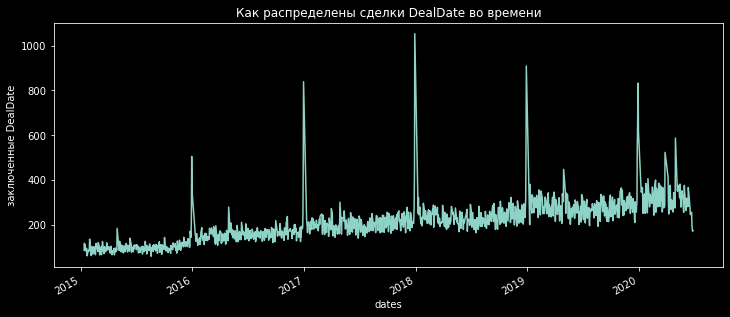

In [52]:
# Как распределены сделки DealDate во времени

deals_to_time = data.DealDate.value_counts()
plt.title('Как распределены сделки DealDate во времени')
plt.ylabel('заключенные DealDate')
plt.xlabel('dates')
deals_to_time.plot();


#### виден всплеск сделок, открытых в конце года


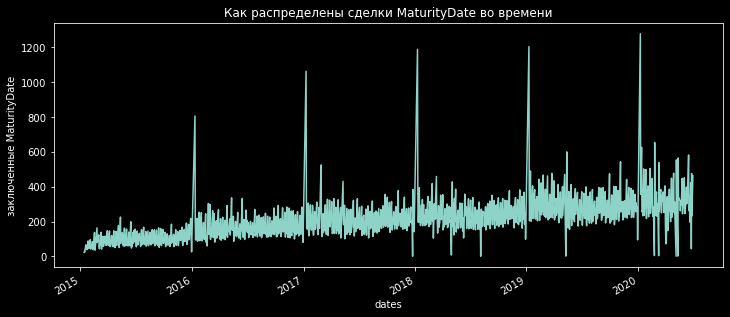

In [53]:
# Как распределены сделки MaturityDate во времени

maturity_to_time = data.MaturityDate.value_counts()
plt.title('Как распределены сделки MaturityDate во времени')
plt.ylabel('заключенные MaturityDate')
plt.xlabel('dates')
maturity_to_time.plot();


#### и также всплеск сделок, завершенных в конце года

In [54]:
print('maturity_to_time.shape', maturity_to_time.shape)
print('deal_to_time.shape', deals_to_time.shape)
print('депозиты открываются - закрываются примерно равномерно')

maturity_to_time.shape (1358,)
deal_to_time.shape (1344,)
депозиты открываются - закрываются примерно равномерно


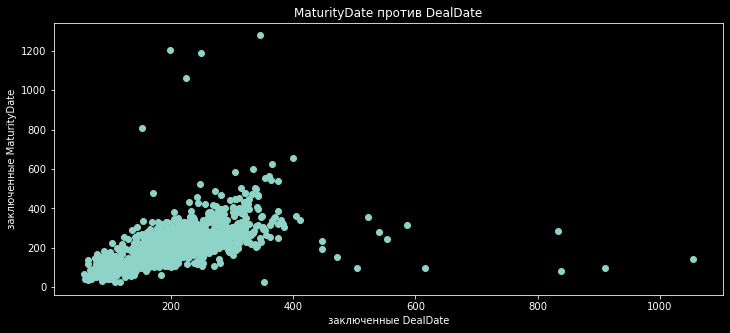

In [55]:
# Как распределены сделки во времени

maturity_vs_deals = pd.DataFrame(deals_to_time).join(maturity_to_time, how='inner')
plt.title('MaturityDate против DealDate')
plt.ylabel('заключенные MaturityDate')
plt.xlabel('заключенные DealDate')
plt.scatter(x=maturity_vs_deals.DealDate, y=maturity_vs_deals.MaturityDate);


#### Есть даты, в которые сделки массово закрывают, не открывая новых

In [56]:
client_id_activity = data.groupby(data.Client_Id).agg(['count', 'mean', 'median', 'std'])
client_id_activity.loc[client_id_activity['target']['count'] > 100]\
    .sort_values(by=('DealDurationDays', 'count'), ascending=False)

DealDurationDays                              DealDurationMonths  \
                     count       mean median        std              count   
Client_Id                                                                    
0                    16511  13.289988    7.0  33.706482              16511   
7596                  3354   1.527728    1.0   1.168725               3354   
17708                 2159   1.995368    1.0   2.477700               2159   
8269                  1798   5.679088    6.0   2.343586               1798   
11790                 1440  29.759722   26.0  25.718188               1440   
...                    ...        ...    ...        ...                ...   
7703                   102  14.264706   14.0   5.507738                102   
7074                   102  14.911765   10.5  17.740206                102   
13868                  101  33.435644   31.0  19.514311                101   
13209                  101   2.306931    1.0   4.706894                101   
12230                  101   1.712871    1.0   1.336687                101   

                                     Deal_characteristics_1            ...  \
               mean median       std                  count      mean  ...   
Client_Id                                                              ...   
0          0.245533    0.0  1.105534                  16511  1.217816  ...   
7596       0.000000    0.0  0.000000                   3354  6.078429  ...   
17708      0.002779    0.0  0.052656                   2159  1.126951  ...   
8269       0.000000    0.0  0.000000                   1798  0.155975  ...   
11790      0.502778    0.0  0.911661                   1440  0.065319  ...   
...             ...    ...       ...                    ...       ...  ...   
7703       0.000000    0.0  0.000000                    102  0.106067  ...   
7074       0.147059    0.0  0.533938                    102  0.306274  ...   
13868      0.623762    1.0  0.661082                    101  0.164703  ...   
13209      0.009901    0.0  0.099504                    101  2.345934  ...   
12230      0.000000    0.0  0.000000                    101  0.304810  ...   

          Client_characteristics_1           Client_characteristics_2  \
                            median       std                    count   
Client_Id                                                               
0                             13.0  5.105001                    16511   
7596                           7.0  3.886604                     3354   
17708                         15.0  0.000000                     2159   
8269                          15.0  4.959581                     1798   
11790                         15.0  6.016724                     1440   
...                            ...       ...                      ...   
7703                          15.0  0.000000                      102   
7074                          15.0  0.000000                      102   
13868                         15.0  0.000000                      101   
13209                         15.0  3.846047                      101   
12230                          9.0  2.566502                      101   

                                           target                             
                  mean  median         std  count      mean median       std  
Client_Id                                                                     
0          1308.604869  1737.0  568.341181  16511  0.656593    1.0  0.474860  
7596        945.031306   954.0  446.414313   3354  0.816041    1.0  0.387509  
17708      1759.000000  1759.0    0.000000   2159  0.972673    1.0  0.163074  
8269       1003.870968  1759.0  859.991409   1798  0.992770    1.0  0.084747  
11790      1467.660417  1759.0  436.957491   1440  0.860417    1.0  0.346675  
...                ...     ...         ...    ...       ...    ...       ...  
7703       1759.000000  1759.0    0.000000    102  0.137255    0.0  0.345816  
7074       

In [57]:
gr = client_id_activity['target'].groupby('count')
gr.agg('mean')

,mean,median,std
count,,,
1,0.171959,0.171959,NaN
2,0.296652,0.296652,0.237070
3,0.374828,0.341128,0.311706
4,0.395413,0.375229,0.342719
5,0.449151,0.436014,0.381428
...,...,...,...
1440,0.860417,1.000000,0.346675
1798,0.992770,1.000000,0.084747
2159,0.972673,1.000000,0.163074


    клиенты, совершившие одну сделку за ~5лет, редко продлевают депозит
    а есть те, кто много раз продлевал депозиты
    
####    дальше показано, что таких клиентов очень мало


In [58]:
gr = client_id_activity['target'].groupby('count').agg(['count'])['mean']
gr['fraction'] = gr['count'] / unique_clients
gr['cum_fraction'] = np.cumsum(gr['count']) / unique_clients
gr.index.name = 'deals'
gr.head(15)

,count,fraction,cum_fraction
deals,,,
1,4472,0.255222,0.255222
2,2240,0.127839,0.383061
3,1454,0.082981,0.466043
4,1090,0.062208,0.528250
5,883,0.050394,0.578644
6,688,0.039265,0.617909
7,567,0.032359,0.650268
8,471,0.026880,0.677149
9,421,0.024027,0.701176


####    72% клиентов совершили не более 10 сделок
####    79% - не более 15


клиенты с высокой частотностью сделок, 
чаще продлевают депозит
ниже показаны клиенты от 1 до 20 сделок


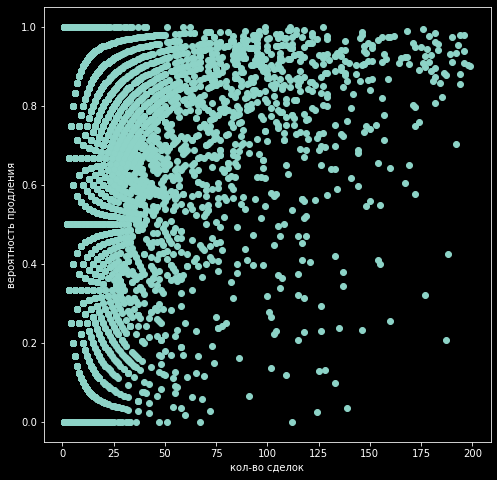

In [59]:
# Как зависит вероятность продления от активности клиента ()
print(f'клиенты с высокой частотностью сделок, \n'
      f'чаще продлевают депозит\n'
      f'ниже показаны клиенты от 1 до 20 сделок')
clients_less_2000 = client_id_activity.loc[client_id_activity['target']['count'] < 200]
fig = plt.figure(figsize=(8, 8))
plt.scatter(clients_less_2000['target']['count'],
         clients_less_2000['target']['mean']);
plt.xlabel('кол-во сделок');
plt.ylabel('вероятность продления');

## Средняя вероятность продления сделки (y) и частота сделок


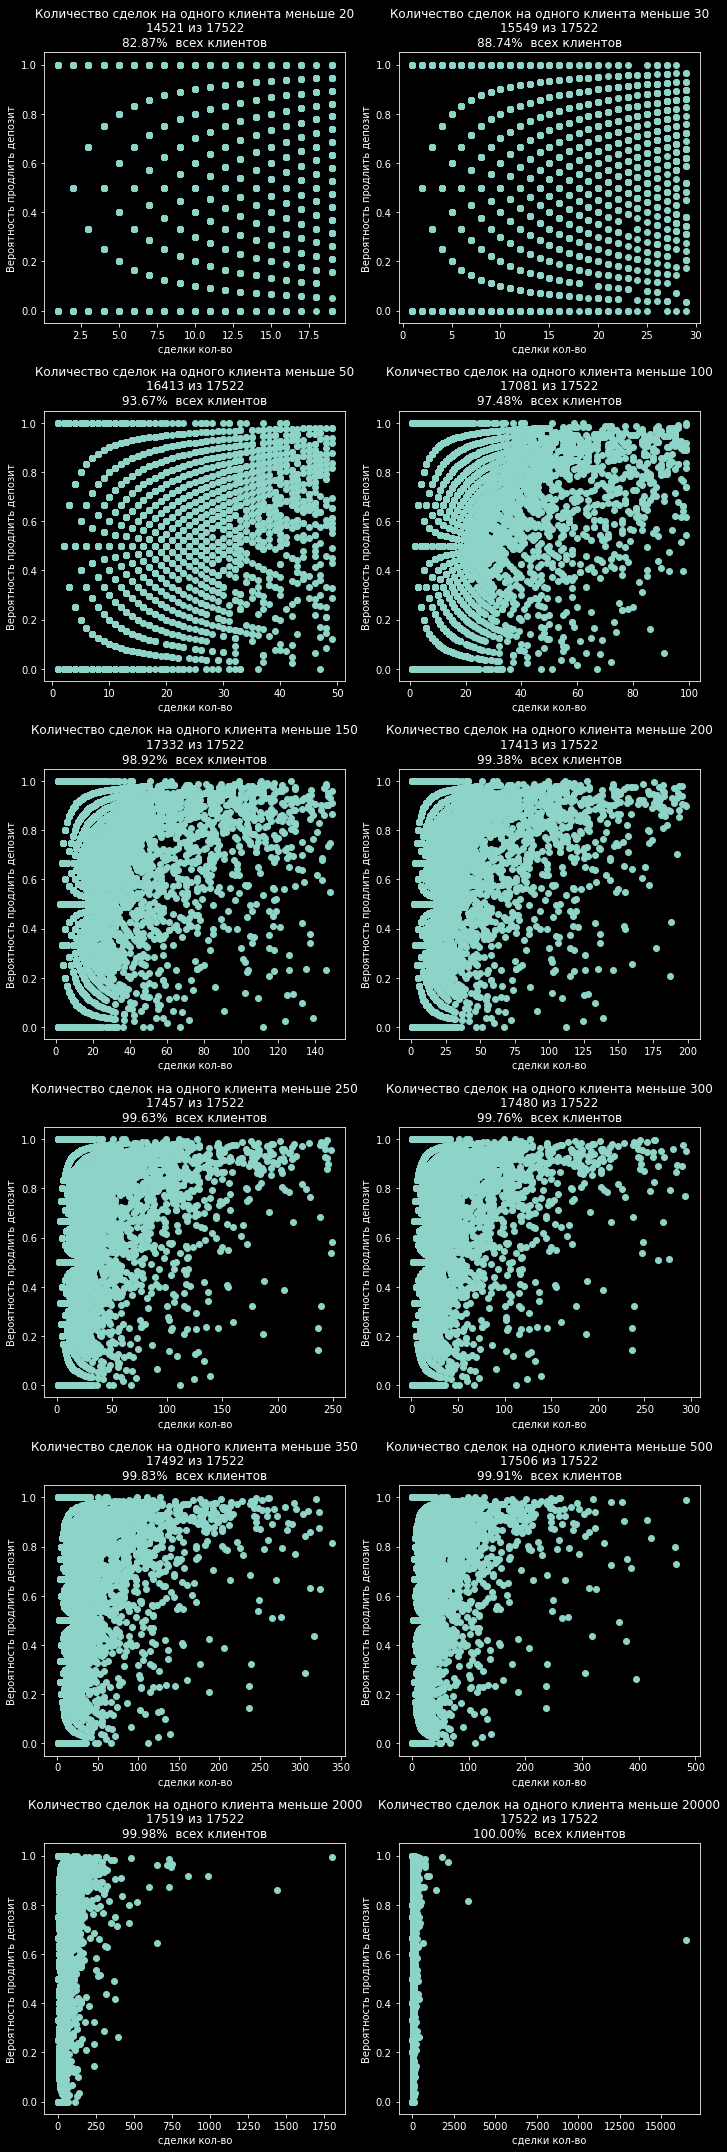

In [60]:
# ndeals = [50, 100, range(150, 300, 50), 500, 2000, 20000]
ndeals = [20, 30, 50, 100, *list(range(150, 400, 50)), 500, 2000, 20000]
nrows = int(len(ndeals) / 2)
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))

for ax, gamma in zip(axs.flat, ndeals):
    clients_less_gamma = client_id_activity.loc[client_id_activity['target']['count'] < gamma]
    ax.set_title(
         f'Количество сделок на одного клиента меньше {gamma}\n'
         f'{clients_less_gamma.shape[0]} из {unique_clients}\n'
         f'{(clients_less_gamma.shape[0] / unique_clients)*100:.2f}%  всех клиентов'
         )
    ax.scatter(clients_less_gamma['target']['count'],
               clients_less_gamma['target']['mean'],
               )
    ax.set_xlabel("сделки кол-во")
    ax.set_ylabel("Вероятность продлить депозит")
fig.tight_layout()
plt.show();

## Логарифм средней вероятности продления сделки (y) и частота сделок


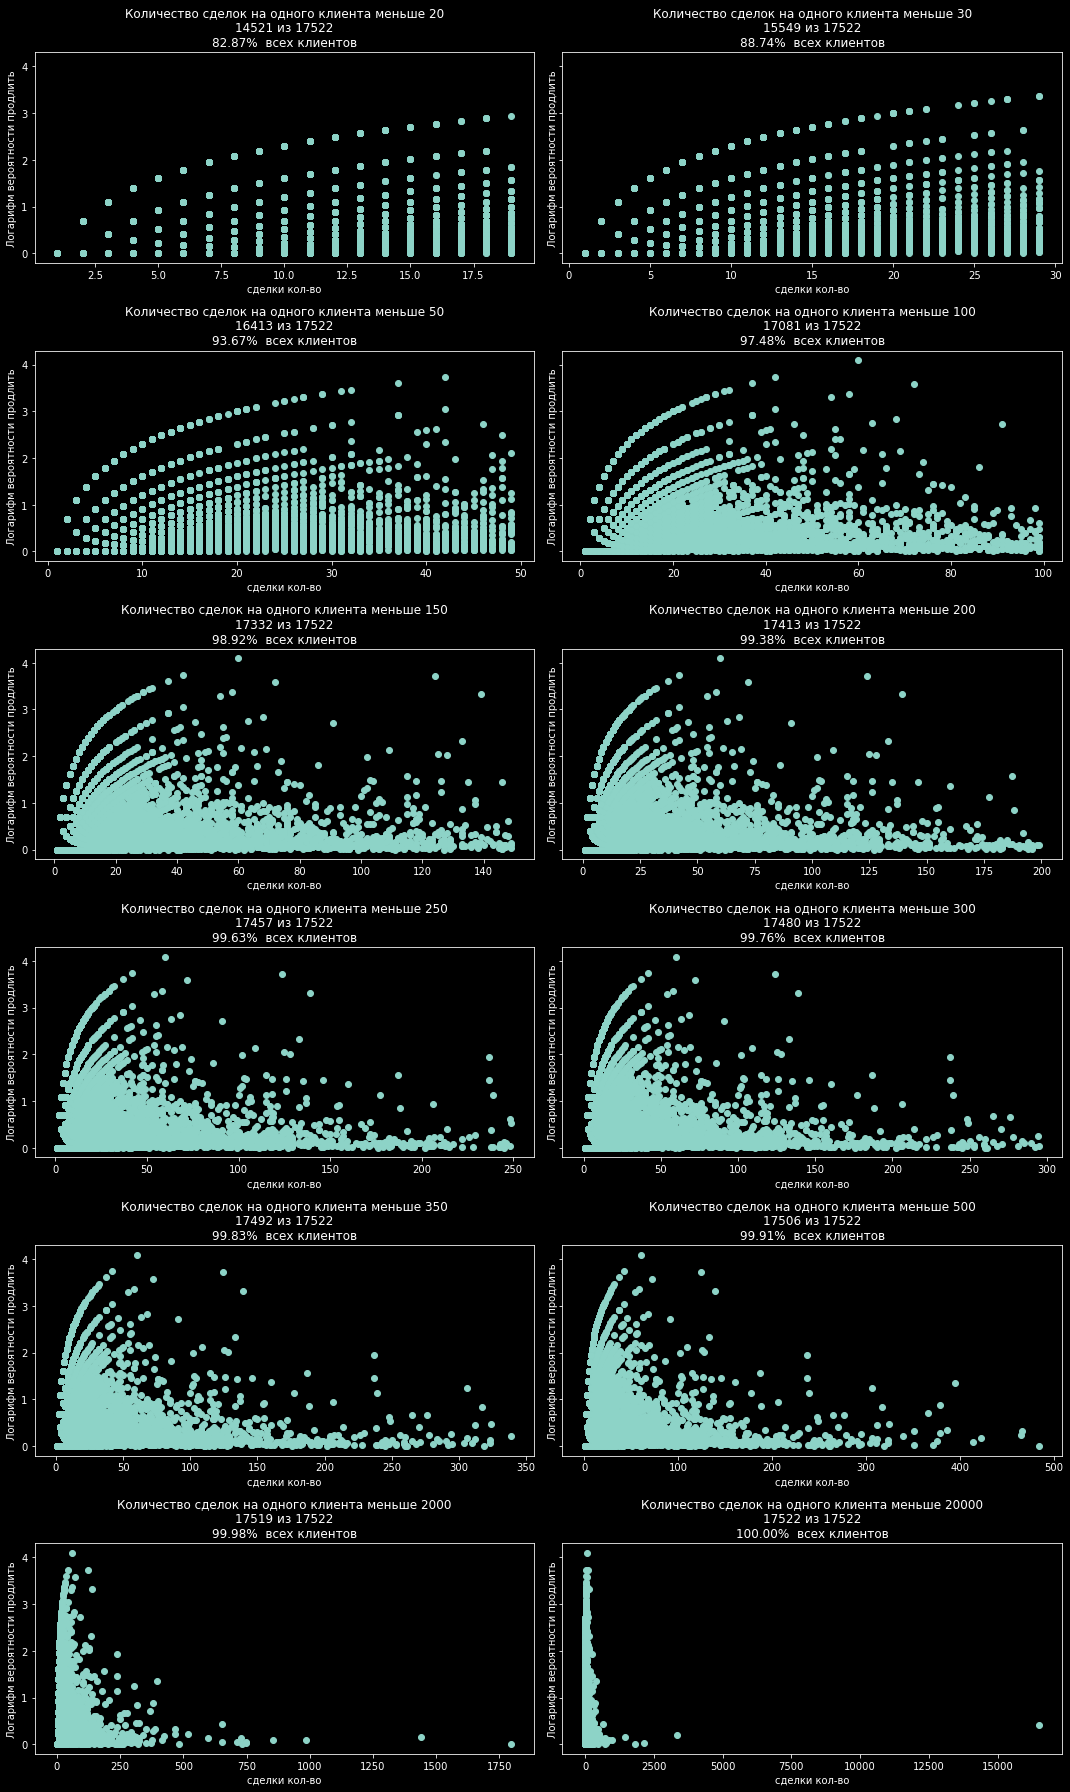

In [61]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25), sharey=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for ax, gamma in zip(axs.flat, ndeals):
        clients_less_gamma = client_id_activity.loc[client_id_activity['target']['count'] < gamma]
        ax.set_title(f'Количество сделок на одного клиента меньше {gamma}\n'
                     f'{clients_less_gamma.shape[0]} из {unique_clients}\n'
                     f'{(clients_less_gamma.shape[0] / unique_clients)*100:.2f}%  всех клиентов' )
        ax.scatter(clients_less_gamma['target']['count'],
                 -np.log(clients_less_gamma['target']['mean']),
                   )
        ax.set_xlabel("сделки кол-во")
        ax.set_ylabel("Логарифм вероятности продлить")

fig.tight_layout()
plt.show();

##    Средняя продолжительность сделки (y) и частота сделок
    Чем чаще сделки, тем они короче, что довольно естественно
    для клиентов < 50 сделок практически средняя длина сделок от их частоты зависит мало


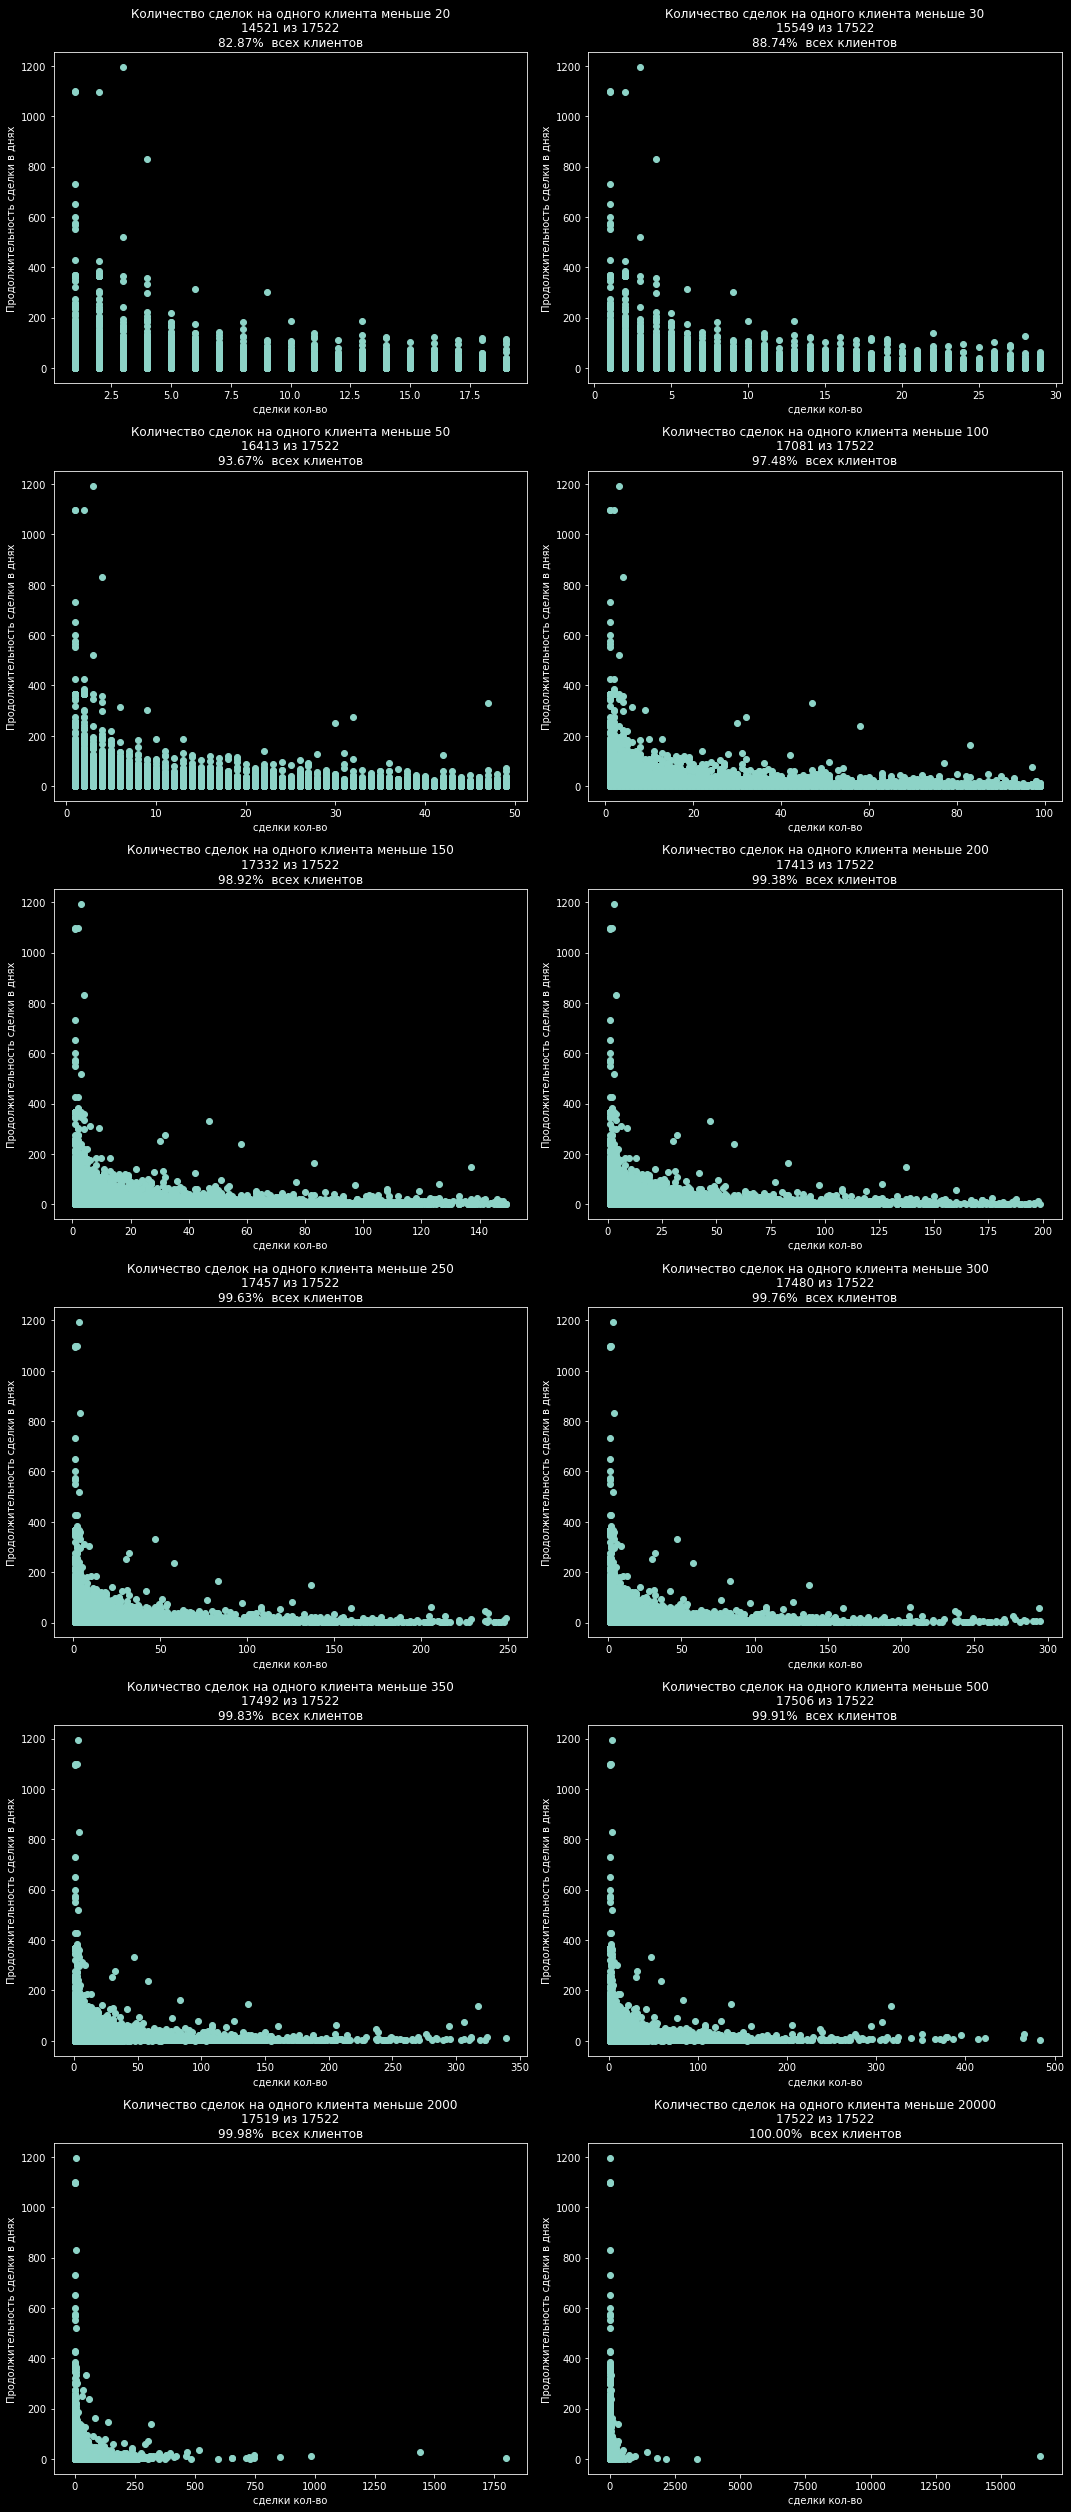

In [62]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 35))

for ax, gamma in zip(axs.flat, ndeals):
    clients_less_gamma = client_id_activity.loc[client_id_activity['target']['count'] < gamma]
    ax.set_title(f'Количество сделок на одного клиента меньше {gamma}\n'
                 f'{clients_less_gamma.shape[0]} из {unique_clients}\n'
                 f'{(clients_less_gamma.shape[0] / unique_clients)*100:.2f}%  всех клиентов' )
    ax.scatter(clients_less_gamma['target']['count'],
             clients_less_gamma['DealDurationDays']['mean'],
               )
    ax.set_xlabel("сделки кол-во")
    ax.set_ylabel("Продолжительность сделки в днях")

fig.tight_layout()
plt.show();

## клиенты с числом сделок меньше 200 за 1995 дней - гистограмма

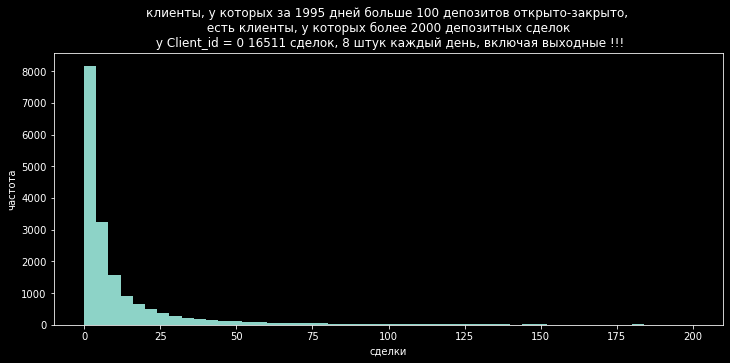

In [63]:
# client_id_activity_target.drop(labels=[0], inplace=True)
n, bins, patches = plt.hist(client_id_activity['target']['count'], bins=50, range=(0, 200));
# plt.title('клиенты с числом сделок меньше 200 зв 1995 дней')
plt.title(
    ('клиенты, у которых за 1995 дней больше 100 депозитов открыто-закрыто, \n '
      'есть клиенты, у которых более 2000 депозитных сделок \n'
      ' у Client_id = 0 16511 сделок, 8 штук каждый день, включая выходные !!!')
)
plt.xlabel('сделки')
plt.ylabel('частота');
# plt.plot(bins[:10])

In [64]:
# client_id_activity_target.loc[client_id_activity_target['count'] > 200]['mean'].hist(bins=50)
# client_id_activity_target.loc[client_id_activity_target['count'] > 200]['median'].hist(bins=50)


In [65]:
def deal_duration_info(duration: pd.Series, label: str) -> None:
    """
        Графики и основные статистики, квантили для ряда с длиной сделки в днях
    :param duration: длина сделки
    :param label: метка - строка в заголовок графика
    :return: None
    """
    print(label)
    print('mean', f"{duration.mean().astype(int)}")
    print('max', f"{duration.max().astype(int)}")
    print('min', f"{duration.min().astype(int)}")
    # quantiles
    for quantile in [20, 50, 70, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]:
        ndays = np.percentile(duration.values, quantile).astype(int)
        print(f'{quantile}% {ndays} days {ndays // 30} months')

    print(f"std {duration.values.astype('int64').std().astype(int)}")
    print('nuniques', duration.nunique())

    # fig = plt.figure(figsize=(15, 8))
    plt.hist(x=duration, bins=150)
    plt.title(label)
    plt.xlabel("days")
    plt.ylabel('frequency')
    # plt.legend()
    plt.grid()
    plt.show()
    # fig = px.histogram(duration, title=duration.name, nbins=10)
    # fig.show()

0-100% квантиль 
90% клиентов держат деньги не больше месяца, 
т.е. к следующей зарплате на счету ничего не остается,
mean 12
max 1461
min 1
20% 1 days 0 months
50% 7 days 0 months
70% 10 days 0 months
90% 31 days 1 months
91% 31 days 1 months
92% 32 days 1 months
93% 33 days 1 months
94% 34 days 1 months
95% 38 days 1 months
96% 48 days 1 months
97% 62 days 2 months
98% 89 days 2 months
99% 98 days 3 months
std 27
nuniques 391


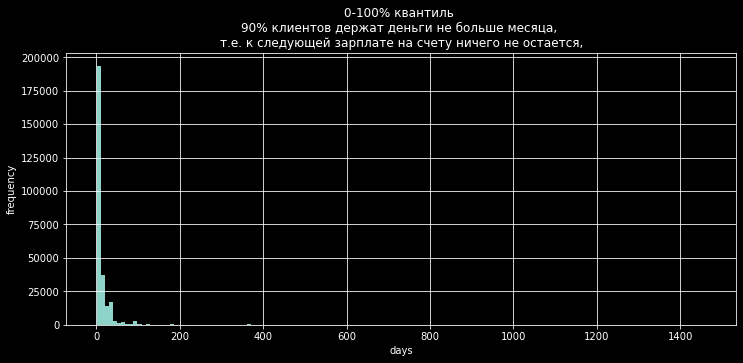

In [66]:
deal_duration_info(
   data.DealDurationDays,
   label=('0-100% квантиль \n'
       '90% клиентов держат деньги не больше месяца, \n'
       'т.е. к следующей зарплате на счету ничего не остается,'))

## посмотрим на квантиль 90% - 100%

quantile 90% - 100% 
выбросы мешают, 
посмотрим, как выглядит интерквантиль 90% - 99%
mean 69
max 1461
min 32
20% 33 days 1 months
50% 45 days 1 months
70% 68 days 2 months
90% 111 days 3 months
91% 121 days 4 months
92% 130 days 4 months
93% 151 days 5 months
94% 177 days 5 months
95% 183 days 6 months
96% 187 days 6 months
97% 240 days 8 months
98% 364 days 12 months
99% 366 days 12 months
std 69
nuniques 360


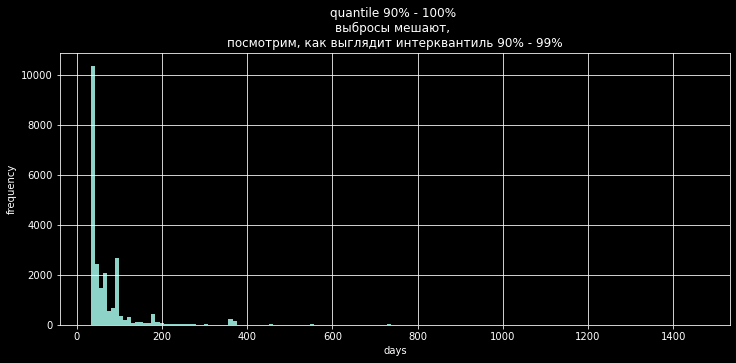

In [67]:
duration90_100 = data.DealDurationDays[data.DealDurationDays > 31]
deal_duration_info(
    duration90_100,
    label=('quantile 90% - 100% \n'
    'выбросы мешают, \n'
    'посмотрим, как выглядит интерквантиль 90% - 99%')
)
print()

## посмотрим, как выглядит интерквантиль 90% - 99%

90-99% интерквартиль 
держат деньги на депозите от 1 до 3 месяцев
mean 50
max 97
min 32
20% 33 days 1 months
50% 41 days 1 months
70% 60 days 2 months
90% 91 days 3 months
91% 91 days 3 months
92% 91 days 3 months
93% 91 days 3 months
94% 92 days 3 months
95% 92 days 3 months
96% 92 days 3 months
97% 93 days 3 months
98% 94 days 3 months
99% 95 days 3 months
std 21
nuniques 66


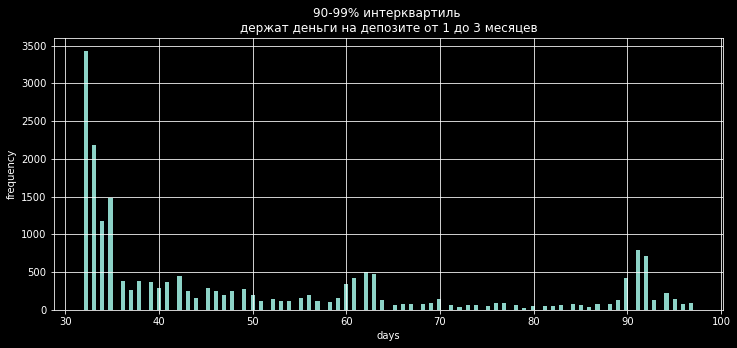

In [68]:
duration90_99 = data.DealDurationDays[(data.DealDurationDays > np.quantile(data.DealDurationDays.values,  .90))
                                  & (data.DealDurationDays < np.quantile(data.DealDurationDays.values,  .99))]
deal_duration_info(
    duration90_99,
    label="90-99% интерквартиль \n"
    "держат деньги на депозите от 1 до 3 месяцев")

365+ дней 
В основном после года депозит забирают
mean 468
max 1461
min 366
20% 366 days 12 months
50% 368 days 12 months
70% 459 days 15 months
90% 732 days 24 months
91% 732 days 24 months
92% 732 days 24 months
93% 732 days 24 months
94% 733 days 24 months
95% 760 days 25 months
96% 1094 days 36 months
97% 1096 days 36 months
98% 1096 days 36 months
99% 1098 days 36 months
std 189
nuniques 65


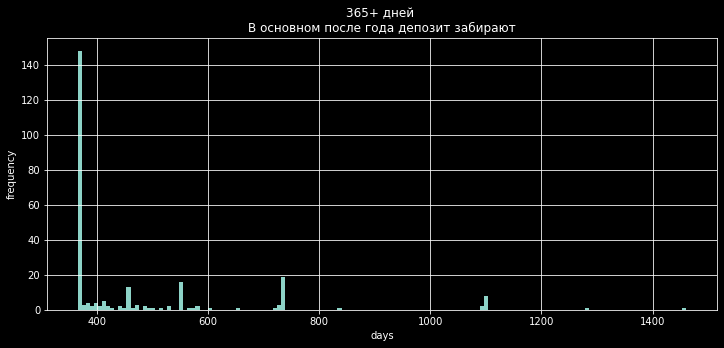

In [69]:
duration_year_plus = data.DealDurationDays[(data.DealDurationDays > 365)]
deal_duration_info(
    duration_year_plus,
    label=("365+ дней \n"
           "В основном после года депозит забирают"))

#### В основном после года депозит забирают

In [26]:
value_counts = data.target.value_counts()
print('Дисбаланс классов')
print(value_counts)
print(value_counts[1]/value_counts[0])
print('первого класса больше')

Дисбаланс классов
True     184120
False     90582
Name: target, dtype: int64
2.0326334150272682
первого класса больше


In [70]:
float_deal_characteristics = ['Deal_characteristics_1', 'Deal_characteristics_2',
       'Deal_characteristics_3']

def float_deal_char_info(deal_characteristic: pd.Series, label: str):
    print(label)
    print("nunique", deal_characteristic.nunique())


In [71]:
float_deal_char_info(data.Deal_characteristics_1, label="Deal_characteristics_1")

Deal_characteristics_1
nunique 41673


In [72]:
float_deal_char_info(data.Deal_characteristics_2, label="Deal_characteristics_2")

Deal_characteristics_2
nunique 1245


In [73]:
float_deal_char_info(data.Deal_characteristics_3, label="Deal_characteristics_3")

Deal_characteristics_3
nunique 21999


In [74]:
print(data.Deal_characteristics_4.unique())

group4 = data.groupby(by='Deal_characteristics_4')

[0 2 1]


In [75]:
print('group4.mean()')
group4.mean()

group4.mean()


,DealDurationDays,DealDurationMonths,Client_Id,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,,
0,16.744210,0.356370,11016.392499,0.976521,0.061779,0.085586,12.384288,1488.732714,0.682207
1,13.882973,0.183904,14678.116561,0.968889,0.058384,0.086138,14.986631,1753.665048,0.668440
2,11.815466,0.184613,11855.634745,0.978426,0.057533,0.083673,11.579394,1427.478410,0.668847


In [76]:
print('group4.median()')
group4.median()

group4.median()


,DealDurationDays,DealDurationMonths,Client_Id,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,,
0,4.0,0,11095,0.149856,0.0559,0.083749,15,1759,1
1,7.0,0,17708,0.210812,0.0536,0.086089,15,1759,1
2,7.0,0,11836,0.306237,0.0532,0.081100,15,1759,1


In [77]:
print('group4.std()')
group4.std()

group4.std()


,DealDurationDays,DealDurationMonths,Client_Id,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,,
0,48.505187,1.583508,7544.537297,4.280479,0.022964,0.019573,4.908261,534.539080,0.465626
1,22.017365,0.701831,7626.863996,3.205136,0.017522,0.011843,0.279835,78.106146,0.470782
2,23.615353,0.760209,7547.299625,3.731940,0.017901,0.016359,4.790609,515.873421,0.470629


count    274702.000000
mean         12.039789
std           4.658258
min           0.000000
25%           9.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: Client_characteristics_1, dtype: float64

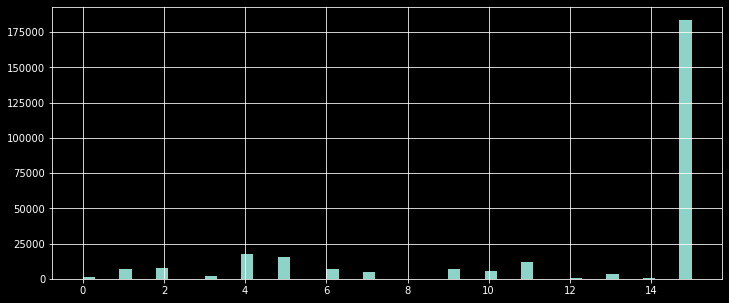

In [78]:
data.Client_characteristics_1.hist(bins=50)
data.Client_characteristics_1.describe()

count    274702.000000
mean       1469.837318
std         500.050468
min           0.000000
25%        1297.000000
50%        1759.000000
75%        1759.000000
max        1759.000000
Name: Client_characteristics_2, dtype: float64

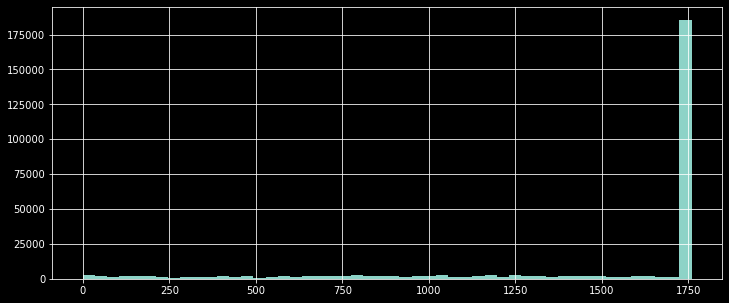

In [79]:
data.Client_characteristics_2.hist(bins=50, figsize=(12, 5))
data.Client_characteristics_2.describe()


In [83]:
nodates = [col for col in data.columns if col not in config.dates ]


In [84]:
maturity_count = data.MaturityDate.value_counts()
deal_count = data.DealDate.value_counts()
maturity_count

2020-01-09    1278
2019-01-09    1204
2018-01-09    1188
2017-01-09    1062
2016-01-11     806
              ... 
2020-05-11       2
2019-05-10       2
2018-08-04       1
2020-05-05       1
2017-12-24       1
Name: MaturityDate, Length: 1358, dtype: int64

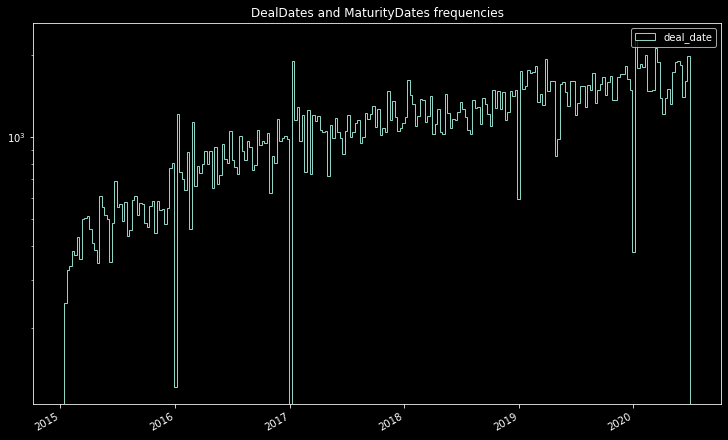

In [85]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
# matutity_hist_values = plt.hist(maturity_count, bins=50, label='maturity')
# deal_hist_values = plt.hist(deal_count, bins=50)

# matutity_hist_values = ax.hist(maturity_count, bins=50, label='maturity')
# deal_hist_values = plt.hist(deal_count, bins=50, label='deal_date')

# ax.hist(data.DealDate, label='maturity', histtype='step', bins=250)
maturity_ax = ax.hist(data.MaturityDate, label='deal_date', histtype='step', bins=250, log=True)
# print(maturity_ax)
# ax.barh(importances_np[1], importances_np[0], align='center');
plt.legend()
plt.title('DealDates and MaturityDates frequencies')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");